<a href="https://colab.research.google.com/github/theoVasilas/Diplomatic_incident/blob/Centralized-training/other_datasets_Central_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General

In [ ]:
!pip install thop
!pip install codecarbon

In [ ]:
from google.colab import drive
import pandas as pd
import os
import matplotlib.pyplot as plt
from codecarbon import EmissionsTracker

In [ ]:
file_path = '/content/drive/MyDrive/Sxoli/EFREMIDIS/Dataset_Baseline/data'

dataset_location = "dataset_location"

dataset_location_path = os.path.join(file_path, dataset_location)

if not os.path.exists(dataset_location_path):
        raise IOError(f"{dataset_location_path} not found.")
else :
    print(f"{dataset_location_path} found.")



/content/drive/MyDrive/Sxoli/EFREMIDIS/Dataset_Baseline/data/dataset_location found.


In [ ]:
dataset_texas = "dataset_texas/100"

dataset_texas_path = os.path.join(file_path, dataset_texas)

if not os.path.exists(dataset_texas_path):
        raise IOError(f"{dataset_texas_path} not found.")
else :
    print(f"{dataset_texas_path} found.")


/content/drive/MyDrive/Sxoli/EFREMIDIS/Dataset_Baseline/data/dataset_texas/100 found.


In [ ]:
dataset_purchase = "dataset_purchase"

dataset_purchase_path = os.path.join(file_path, dataset_purchase)

if not os.path.exists(dataset_purchase_path):
        raise IOError(f"{dataset_purchase_path} not found.")
else :
    print(f"{dataset_purchase_path} found.")

/content/drive/MyDrive/Sxoli/EFREMIDIS/Dataset_Baseline/data/dataset_purchase found.


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# dataloader

In [ ]:
import numpy as np
import os
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

def load_dataset(folder_path, num_of_training_set=2, val_split = 0.2, verbose = False):

    num_of_training_set = int(num_of_training_set)

    # Construct file paths
    data_feat_path = os.path.join(folder_path, "features")
    data_label_path = os.path.join(folder_path, "labels")

    # Check if files exist
    if not os.path.exists(data_feat_path):
        raise IOError(f"{data_feat_path} not found.")
    else :
        print(f"{data_feat_path} found.") if verbose == True else None
    if not os.path.exists(data_label_path):
        raise IOError(f"{data_label_path} not found.")
    else :
        print(f"{data_label_path} found.") if verbose == True else None


    data_feat =  np.loadtxt(data_feat_path, delimiter=',', dtype='float32') # Ram expencive
    data_label =  np.loadtxt(data_label_path, dtype='int32')
    print(data_label[:3]) if verbose == True else None
    print(data_feat[:10]) if verbose == True else None

    min_label = np.min(data_label)
    data_label -= min_label # Normilazetion(not that nessesery)

    print(f"lenght of all the data is : {len(data_feat)}") if verbose == True else None

    # Split data into training and testing sets
    train_feat = data_feat[:num_of_training_set]
    train_label = data_label[:num_of_training_set]
    test_feat = data_feat[num_of_training_set:]
    test_label = data_label[num_of_training_set:]

    print(f"Length of training data: {len(train_feat)}") if verbose == True else None
    print(f"Length of testing data: {len(test_feat)}") if verbose == True else None

    if min(train_label) == 0 :
        num_classes = max(train_label)+1
    else :
        num_classes = max(train_label)
    print(f"num of labels: {num_classes}")  if verbose == True else None

    # Convert features and labels to PyTorch tensors
    train_feat_tensor = torch.tensor(train_feat, dtype=torch.float32)
    train_label_tensor = torch.tensor(train_label, dtype=torch.long)
    test_feat_tensor = torch.tensor(test_feat, dtype=torch.float32)
    test_label_tensor = torch.tensor(test_label, dtype=torch.long)

    # Create TensorDataset for training and testing sets
    train_dataset = TensorDataset(train_feat_tensor, train_label_tensor)
    test_dataset = TensorDataset(test_feat_tensor, test_label_tensor)

    # Split training data into train and validation datasets
    val_size = int(len(train_dataset) * val_split)
    train_size = len(train_dataset) - val_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    print(f"Training size: {train_size}, Validation size: {val_size}") if verbose == True else None

    # Create DataLoader for training and testing
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    features, label = train_loader.__iter__().__next__()
    print(features.shape)if verbose == True else None
    print(label.shape)if verbose == True else None

    return train_loader, val_loader, test_loader

In [ ]:
num_of_train = 10000

train_loader, val_loader, test_loader = load_dataset(dataset_purchase_path, num_of_train, verbose = True)

/content/drive/MyDrive/Sxoli/EFREMIDIS/Dataset_Baseline/data/dataset_purchase/features found.
/content/drive/MyDrive/Sxoli/EFREMIDIS/Dataset_Baseline/data/dataset_purchase/labels found.
[63 70 67]
[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 1.]]
lenght of all the data is : 197324
Length of training data: 10000
Length of testing data: 187324
num of labels: 100
Training size: 8000, Validation size: 2000
torch.Size([128, 600])
torch.Size([128])


# train test func

In [ ]:
from tqdm import tqdm  # For progress bars

def train(
    net,
    trainloader,
    valloader,
    optimizer,
    epochs,
    scheduler=None,
    verbose = False,
    save_anable = False
):

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(DEVICE)

    criterion = torch.nn.CrossEntropyLoss()
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    # Training loop
    for epoch in range(epochs):
        lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{epochs} - Learning Rate: {lr}")

        net.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        # Training Phase
        for features, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs} (Training)"):
            try:
                features, labels = features.to(DEVICE), labels.to(DEVICE)
                optimizer.zero_grad()
                outputs = net(features)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # Metrics
                train_loss += loss.item()
                train_total += labels.size(0)
                predictions = torch.argmax(outputs, dim=1)
                train_correct += (predictions == labels).sum().item()
            except Exception as e:
                print(f"Error in training step: {e}")

        if (epoch + 1) % 10 == 0 and save_anable == True :
            filename = f'checkpoint_epoch_{epoch+1}.pth'
            torch.save(net, filename)
            print(f"Entire model saved to {filename}")

        # Compute averages
        train_loss /= len(trainloader)
        train_acc = train_correct / train_total

        # Validation Phase
        net.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for features, labels in tqdm(valloader, desc=f"Epoch {epoch+1}/{epochs} (Validation)"):
                try:
                    features, labels = features.to(DEVICE), labels.to(DEVICE)
                    outputs = net(features)
                    loss = criterion(outputs, labels)

                    # Metrics
                    val_loss += loss.item()
                    val_total += labels.size(0)
                    predictions = torch.argmax(outputs, dim=1)
                    val_correct += (predictions == labels).sum().item()
                except Exception as e:
                    print(f"Error in validation step: {e}")

        # Compute averages
        val_loss /= len(valloader)
        val_acc = val_correct / val_total

        if 'scheduler' in locals() and scheduler is not None:
            # Step the scheduler
            scheduler.step()

        # Save metrics to history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Verbose logging
        if verbose:
            print(
                f"Epoch {epoch+1}/{epochs} "
                f"- Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
                f"- Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
            )

        if val_acc >= 0.90:
              print(f"Early stopping: Validation accuracy reached {accuracy_threshold*100}%")
              break

    return history


In [ ]:
def test(net, testloader):
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(DEVICE)

    criterion = torch.nn.CrossEntropyLoss()
    net.eval()  # Set the model to evaluation mode
    test_loss, test_correct, test_total = 0.0, 0, 0

    with torch.no_grad():  # No gradient calculation during testing
        for features, labels in tqdm(testloader, desc="Testing"):
            try:
                features, labels = features.to(DEVICE), labels.to(DEVICE)
                outputs = net(features)
                loss = criterion(outputs, labels)

                # Metrics
                test_loss += loss.item()
                test_total += labels.size(0)
                predictions = torch.argmax(outputs, dim=1)
                test_correct += (predictions == labels).sum().item()
            except Exception as e:
                print(f"Error in testing step: {e}")

    # Compute averages
    test_loss /= len(testloader)
    test_acc = test_correct / test_total

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    return test_loss, test_acc


# models

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Simple_Net(nn.Module):
    def __init__(self, input_size: int, num_classes: int) -> None:
        """
        Args:
            input_channels: Number of input channels in the data.
            num_classes: Number of output classes.
        """
        super(Simple_Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    def reset(self):
        for layer in self.children():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                layer.reset_parameters()


In [ ]:
from torchsummary import summary
from thop import profile

def initialize_Simple_Net(folder_path, verbose = False):

    train_loader, _, _ = load_dataset(folder_path, num_of_train)
    features, label = train_loader.__iter__().__next__()
    input_size = features.shape[1]  # C dimension
    num_classes = max(label) + 1  # Number of classes

    model = Simple_Net(input_size=input_size, num_classes=num_classes)
    output = model(features)

    num_parameters = sum(value.numel() for value in model.state_dict().values())

    summary(model, (input_size,))

    input_tensor = torch.randn(1, input_size)
    flops, params = profile(model, inputs=(input_tensor,))
    if verbose == True :
        print(model)
        print("Output shape:", output.shape)
        print(f"{num_parameters = }")
        print(f"FLOPs: {flops}")
        print(f"Parameters: {params}")

    return model

# New_RUN

In [ ]:
import torch
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR, CosineAnnealingWarmRestarts
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

def train_and_evaluate(
    model,
    folder_path,
    dataset_name = "dataset",
    num_of_train=4000,
    epochs=2,
    lr=0.01,
    momentum=0.9,
    weight_decay=5e-4,
    scheduler_step_size=50,
    scheduler_gamma=0.5,
    track = False,
):
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load dataset
    train_loader, val_loader, test_loader = load_dataset(folder_path, num_of_train, verbose=True)

    # Reset and move the model to the device
    model.reset()
    # print(f"Training Model: {model.__class__.__name__}")

    # Define optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    # optimizer = SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    # scheduler = StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)
    # scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
    scheduler = None

    # ========EmissionsTracker===============
    # tracker = EmissionsTracker()
    # if track == True :
    #     tracker.start()
    # =======================================

    # Train the model
    history = train(model,
                    train_loader,
                    val_loader,
                    optimizer,
                    epochs = epochs,
                    verbose=True)

    # ========EmissionsTracker===============
    # if track == True :
    #     emissions: float = tracker.stop()
    #     print(f"Emissions: {emissions * 1000} g CO2eq")
    # =======================================

    # Plot loss and accuracy
    plot_training_history(history)

    # Test the model
    test_loss, test_acc = test(model, test_loader)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

    # Save the model
    model_name = model.__class__.__name__
    filename = f"{dataset_name}_{model_name}.pth"

    torch.save(model.state_dict(), filename)
    print(f"Model saved to {filename}")

    # Load the model back
    model.reset()
    model.load_state_dict(torch.load(filename))
    model = model.to(DEVICE)

    # Evaluate on the test set and generate metrics
    evaluate_model(model, test_loader, DEVICE)

In [ ]:
def plot_training_history(history):
    """Plots training and validation loss/accuracy from history."""
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Accuracy")
    plt.plot(history["val_acc"], label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training and Validation Accuracy")

    plt.tight_layout()
    plt.show()

In [ ]:
def evaluate_model(model, test_loader, device, vervose = False):
    """Computes confusion matrix and class accuracy for a model on the test set."""
    model.eval()  # Set model to evaluation mode
    all_labels, all_preds = [], []
    misclassified_features, misclassified_labels, misclassified_preds = [], [], []

    with torch.no_grad():
        for features, labels in tqdm(test_loader, desc="Evaluating Test Data"):
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            # Find misclassified samples
            incorrect = preds != labels
            misclassified_features.extend(features[incorrect].cpu())
            misclassified_labels.extend(labels[incorrect].cpu())
            misclassified_preds.extend(preds[incorrect].cpu())

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    class_accuracies = np.diag(cm) / cm.sum(axis=1)
    for i, acc in enumerate(class_accuracies):
        print(f"Accuracy for class {i}: {acc:.2f}") if vervose == True else None

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# dataset purchase Training

In [ ]:
model = initialize_Simple_Net(dataset_purchase_path, verbose=True)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         307,712
            Linear-2                  [-1, 256]         131,328
            Linear-3                  [-1, 128]          32,896
            Linear-4                  [-1, 100]          12,900
Total params: 484,836
Trainable params: 484,836
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.85
Estimated Total Size (MB): 1.86
----------------------------------------------------------------
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Simple_Net(
  (fc1): Linear(in_features=600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_feat

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         307,712
            Linear-2                  [-1, 256]         131,328
            Linear-3                  [-1, 128]          32,896
            Linear-4                  [-1, 100]          12,900
Total params: 484,836
Trainable params: 484,836
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.85
Estimated Total Size (MB): 1.86
----------------------------------------------------------------
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
/content/drive/MyDrive/Sxoli/EFREMIDIS/Dataset_Baseline/data/dataset_purchase/features found.
/content/drive/MyDrive/Sxoli/EFREMIDIS/Dataset_Baseline/data/dataset_purchase/labels found.
[63 70 67]
[[0. 1. 0. ... 0. 0. 0.]

Epoch 1/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 197.82it/s]


Epoch 1/50 - Train Loss: 3.7668, Train Acc: 0.0871 - Val Loss: 2.7062, Val Acc: 0.2085
Epoch 2/50 - Learning Rate: 0.01


Epoch 2/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 209.74it/s]


Epoch 2/50 - Train Loss: 2.1853, Train Acc: 0.3235 - Val Loss: 1.8803, Val Acc: 0.3895
Epoch 3/50 - Learning Rate: 0.01


Epoch 3/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 210.40it/s]


Epoch 3/50 - Train Loss: 1.4051, Train Acc: 0.5240 - Val Loss: 1.3572, Val Acc: 0.5405
Epoch 4/50 - Learning Rate: 0.01


Epoch 4/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 203.80it/s]


Epoch 4/50 - Train Loss: 1.0681, Train Acc: 0.6210 - Val Loss: 1.3733, Val Acc: 0.5375
Epoch 5/50 - Learning Rate: 0.01


Epoch 5/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 217.38it/s]


Epoch 5/50 - Train Loss: 0.9079, Train Acc: 0.6725 - Val Loss: 1.2391, Val Acc: 0.5830
Epoch 6/50 - Learning Rate: 0.01


Epoch 6/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 207.79it/s]


Epoch 6/50 - Train Loss: 0.7380, Train Acc: 0.7371 - Val Loss: 1.2800, Val Acc: 0.5910
Epoch 7/50 - Learning Rate: 0.01


Epoch 7/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 187.40it/s]


Epoch 7/50 - Train Loss: 0.6318, Train Acc: 0.7724 - Val Loss: 1.5198, Val Acc: 0.5760
Epoch 8/50 - Learning Rate: 0.01


Epoch 8/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 213.17it/s]


Epoch 8/50 - Train Loss: 0.6034, Train Acc: 0.7800 - Val Loss: 1.4586, Val Acc: 0.5805
Epoch 9/50 - Learning Rate: 0.01


Epoch 9/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 172.88it/s]


Epoch 9/50 - Train Loss: 0.5502, Train Acc: 0.8029 - Val Loss: 1.3805, Val Acc: 0.6095
Epoch 10/50 - Learning Rate: 0.01


Epoch 10/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 124.84it/s]


Epoch 10/50 - Train Loss: 0.5133, Train Acc: 0.8199 - Val Loss: 1.4129, Val Acc: 0.6235
Epoch 11/50 - Learning Rate: 0.01


Epoch 11/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 135.60it/s]


Epoch 11/50 - Train Loss: 0.4897, Train Acc: 0.8275 - Val Loss: 1.4211, Val Acc: 0.6070
Epoch 12/50 - Learning Rate: 0.01


Epoch 12/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 166.89it/s]


Epoch 12/50 - Train Loss: 0.4146, Train Acc: 0.8538 - Val Loss: 1.7553, Val Acc: 0.5940
Epoch 13/50 - Learning Rate: 0.01


Epoch 13/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 220.97it/s]


Epoch 13/50 - Train Loss: 0.4089, Train Acc: 0.8618 - Val Loss: 1.7162, Val Acc: 0.5890
Epoch 14/50 - Learning Rate: 0.01


Epoch 14/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 184.72it/s]


Epoch 14/50 - Train Loss: 0.3479, Train Acc: 0.8816 - Val Loss: 2.0376, Val Acc: 0.5775
Epoch 15/50 - Learning Rate: 0.01


Epoch 15/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 178.85it/s]


Epoch 15/50 - Train Loss: 0.4056, Train Acc: 0.8609 - Val Loss: 1.7599, Val Acc: 0.6080
Epoch 16/50 - Learning Rate: 0.01


Epoch 16/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 228.47it/s]


Epoch 16/50 - Train Loss: 0.2467, Train Acc: 0.9150 - Val Loss: 1.8511, Val Acc: 0.6110
Epoch 17/50 - Learning Rate: 0.01


Epoch 17/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 170.19it/s]


Epoch 17/50 - Train Loss: 0.4041, Train Acc: 0.8670 - Val Loss: 1.9265, Val Acc: 0.6020
Epoch 18/50 - Learning Rate: 0.01


Epoch 18/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 210.33it/s]


Epoch 18/50 - Train Loss: 0.3627, Train Acc: 0.8796 - Val Loss: 2.1137, Val Acc: 0.6095
Epoch 19/50 - Learning Rate: 0.01


Epoch 19/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 132.58it/s]


Epoch 19/50 - Train Loss: 0.2918, Train Acc: 0.9018 - Val Loss: 2.2253, Val Acc: 0.6055
Epoch 20/50 - Learning Rate: 0.01


Epoch 20/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 147.10it/s]


Epoch 20/50 - Train Loss: 0.3060, Train Acc: 0.9024 - Val Loss: 2.1820, Val Acc: 0.6120
Epoch 21/50 - Learning Rate: 0.01


Epoch 21/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 209.07it/s]


Epoch 21/50 - Train Loss: 0.3013, Train Acc: 0.9036 - Val Loss: 2.0464, Val Acc: 0.6100
Epoch 22/50 - Learning Rate: 0.01


Epoch 22/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 242.40it/s]


Epoch 22/50 - Train Loss: 0.3041, Train Acc: 0.9115 - Val Loss: 2.3531, Val Acc: 0.5895
Epoch 23/50 - Learning Rate: 0.01


Epoch 23/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 219.33it/s]


Epoch 23/50 - Train Loss: 0.2480, Train Acc: 0.9229 - Val Loss: 2.6410, Val Acc: 0.5945
Epoch 24/50 - Learning Rate: 0.01


Epoch 24/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 231.05it/s]


Epoch 24/50 - Train Loss: 0.2598, Train Acc: 0.9201 - Val Loss: 2.6707, Val Acc: 0.5910
Epoch 25/50 - Learning Rate: 0.01


Epoch 25/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 207.53it/s]


Epoch 25/50 - Train Loss: 0.2972, Train Acc: 0.9074 - Val Loss: 2.3212, Val Acc: 0.6060
Epoch 26/50 - Learning Rate: 0.01


Epoch 26/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 212.19it/s]


Epoch 26/50 - Train Loss: 0.2291, Train Acc: 0.9285 - Val Loss: 2.6817, Val Acc: 0.6025
Epoch 27/50 - Learning Rate: 0.01


Epoch 27/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 175.20it/s]


Epoch 27/50 - Train Loss: 0.2812, Train Acc: 0.9114 - Val Loss: 2.6299, Val Acc: 0.6080
Epoch 28/50 - Learning Rate: 0.01


Epoch 28/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 126.01it/s]


Epoch 28/50 - Train Loss: 0.2604, Train Acc: 0.9191 - Val Loss: 2.7801, Val Acc: 0.6020
Epoch 29/50 - Learning Rate: 0.01


Epoch 29/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 124.62it/s]


Epoch 29/50 - Train Loss: 0.3786, Train Acc: 0.8985 - Val Loss: 2.7466, Val Acc: 0.5980
Epoch 30/50 - Learning Rate: 0.01


Epoch 30/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 206.42it/s]


Epoch 30/50 - Train Loss: 0.2345, Train Acc: 0.9269 - Val Loss: 2.7727, Val Acc: 0.6135
Epoch 31/50 - Learning Rate: 0.01


Epoch 31/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 208.76it/s]


Epoch 31/50 - Train Loss: 0.2262, Train Acc: 0.9307 - Val Loss: 3.3112, Val Acc: 0.5770
Epoch 32/50 - Learning Rate: 0.01


Epoch 32/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 187.71it/s]


Epoch 32/50 - Train Loss: 0.2313, Train Acc: 0.9316 - Val Loss: 3.0114, Val Acc: 0.5955
Epoch 33/50 - Learning Rate: 0.01


Epoch 33/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 170.81it/s]


Epoch 33/50 - Train Loss: 0.1565, Train Acc: 0.9504 - Val Loss: 2.9563, Val Acc: 0.6145
Epoch 34/50 - Learning Rate: 0.01


Epoch 34/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 209.34it/s]


Epoch 34/50 - Train Loss: 0.1660, Train Acc: 0.9494 - Val Loss: 3.4719, Val Acc: 0.5810
Epoch 35/50 - Learning Rate: 0.01


Epoch 35/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 220.43it/s]


Epoch 35/50 - Train Loss: 0.3590, Train Acc: 0.9050 - Val Loss: 3.3468, Val Acc: 0.5755
Epoch 36/50 - Learning Rate: 0.01


Epoch 36/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 166.28it/s]


Epoch 36/50 - Train Loss: 0.4607, Train Acc: 0.8811 - Val Loss: 2.9253, Val Acc: 0.5630
Epoch 37/50 - Learning Rate: 0.01


Epoch 37/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 115.74it/s]


Epoch 37/50 - Train Loss: 0.3477, Train Acc: 0.8995 - Val Loss: 3.1875, Val Acc: 0.5680
Epoch 38/50 - Learning Rate: 0.01


Epoch 38/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 123.42it/s]


Epoch 38/50 - Train Loss: 0.2473, Train Acc: 0.9264 - Val Loss: 3.0117, Val Acc: 0.6060
Epoch 39/50 - Learning Rate: 0.01


Epoch 39/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 219.53it/s]


Epoch 39/50 - Train Loss: 0.1702, Train Acc: 0.9523 - Val Loss: 3.2942, Val Acc: 0.5725
Epoch 40/50 - Learning Rate: 0.01


Epoch 40/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 196.61it/s]


Epoch 40/50 - Train Loss: 0.2225, Train Acc: 0.9381 - Val Loss: 3.6989, Val Acc: 0.5880
Epoch 41/50 - Learning Rate: 0.01


Epoch 41/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 198.74it/s]


Epoch 41/50 - Train Loss: 0.1810, Train Acc: 0.9480 - Val Loss: 3.2285, Val Acc: 0.5985
Epoch 42/50 - Learning Rate: 0.01


Epoch 42/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 196.22it/s]


Epoch 42/50 - Train Loss: 0.2818, Train Acc: 0.9273 - Val Loss: 3.4082, Val Acc: 0.5925
Epoch 43/50 - Learning Rate: 0.01


Epoch 43/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 206.02it/s]


Epoch 43/50 - Train Loss: 0.2715, Train Acc: 0.9240 - Val Loss: 3.3710, Val Acc: 0.5905
Epoch 44/50 - Learning Rate: 0.01


Epoch 44/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 205.07it/s]


Epoch 44/50 - Train Loss: 0.1990, Train Acc: 0.9413 - Val Loss: 4.2133, Val Acc: 0.5640
Epoch 45/50 - Learning Rate: 0.01


Epoch 45/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 127.48it/s]


Epoch 45/50 - Train Loss: 0.2715, Train Acc: 0.9237 - Val Loss: 3.8000, Val Acc: 0.5860
Epoch 46/50 - Learning Rate: 0.01


Epoch 46/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 125.07it/s]


Epoch 46/50 - Train Loss: 0.2054, Train Acc: 0.9426 - Val Loss: 3.7271, Val Acc: 0.5900
Epoch 47/50 - Learning Rate: 0.01


Epoch 47/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 213.15it/s]


Epoch 47/50 - Train Loss: 0.1943, Train Acc: 0.9469 - Val Loss: 3.8665, Val Acc: 0.5920
Epoch 48/50 - Learning Rate: 0.01


Epoch 48/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 192.61it/s]


Epoch 48/50 - Train Loss: 0.1138, Train Acc: 0.9666 - Val Loss: 4.1089, Val Acc: 0.5895
Epoch 49/50 - Learning Rate: 0.01


Epoch 49/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 192.57it/s]


Epoch 49/50 - Train Loss: 0.2568, Train Acc: 0.9411 - Val Loss: 3.8483, Val Acc: 0.5695
Epoch 50/50 - Learning Rate: 0.01


Epoch 50/50 (Validation): 100%|██████████| 16/16 [00:00<00:00, 202.94it/s]


Epoch 50/50 - Train Loss: 0.2962, Train Acc: 0.9233 - Val Loss: 3.8431, Val Acc: 0.5855


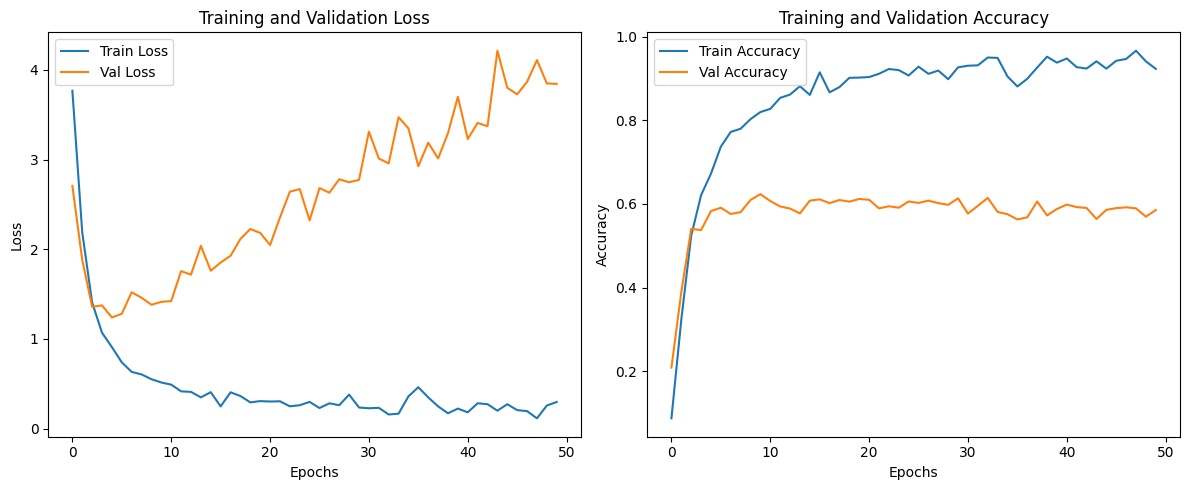

Testing: 100%|██████████| 1464/1464 [00:09<00:00, 158.55it/s]
<ipython-input-13-4cfbbdee5da0>:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.l

Test Loss: 3.8106, Test Accuracy: 0.5774
Test Loss: 3.8106, Test Accuracy: 0.58%
Model saved to dataset_purchase_Simple_Net.pth


Evaluating Test Data: 100%|██████████| 1464/1464 [00:08<00:00, 182.68it/s]


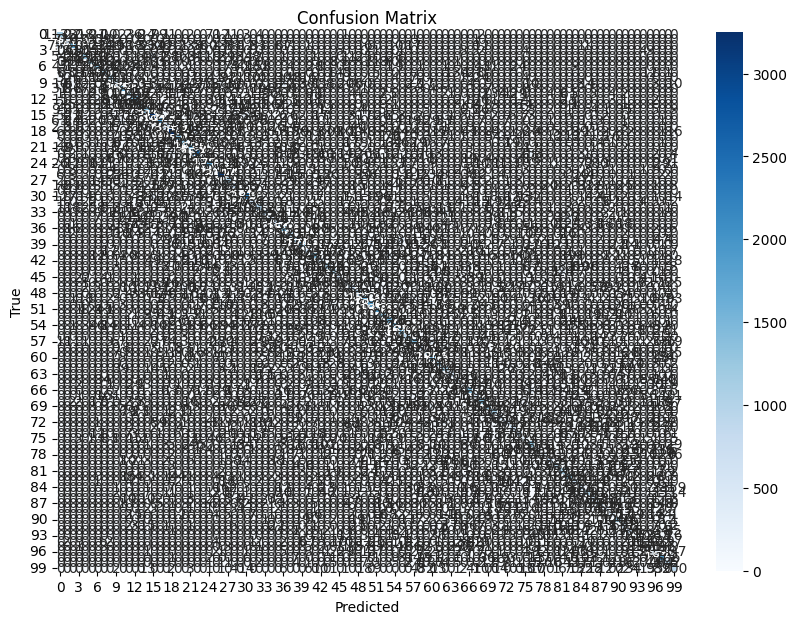

In [ ]:
train_and_evaluate(
    model = initialize_Simple_Net(dataset_purchase_path) ,
    folder_path = dataset_purchase_path,
    dataset_name = "dataset_purchase",
    num_of_train=10000,
    epochs=50,
    lr=0.01,
)

# dataset Locations Training

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         228,864
            Linear-2                  [-1, 256]         131,328
            Linear-3                  [-1, 128]          32,896
            Linear-4                   [-1, 30]           3,870
Total params: 396,958
Trainable params: 396,958
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.51
Estimated Total Size (MB): 1.52
----------------------------------------------------------------
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
/content/drive/MyDrive/Sxoli/EFREMIDIS/Dataset_Baseline/data/dataset_location/features found.
/content/drive/MyDrive/Sxoli/EFREMIDIS/Dataset_Baseline/data/dataset_location/labels found.
[13 11  3]
[[0. 1. 0. ... 0. 0. 0.]

Epoch 1/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 197.80it/s]


Epoch 1/50 - Train Loss: 3.1788, Train Acc: 0.1070 - Val Loss: 2.6689, Val Acc: 0.2281
Epoch 2/50 - Learning Rate: 0.01


Epoch 2/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 216.30it/s]


Epoch 2/50 - Train Loss: 2.0083, Train Acc: 0.3594 - Val Loss: 2.0036, Val Acc: 0.4000
Epoch 3/50 - Learning Rate: 0.01


Epoch 3/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 170.11it/s]


Epoch 3/50 - Train Loss: 1.1283, Train Acc: 0.6172 - Val Loss: 2.1642, Val Acc: 0.3937
Epoch 4/50 - Learning Rate: 0.01


Epoch 4/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 190.19it/s]


Epoch 4/50 - Train Loss: 0.7452, Train Acc: 0.7297 - Val Loss: 2.1199, Val Acc: 0.4844
Epoch 5/50 - Learning Rate: 0.01


Epoch 5/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 211.27it/s]


Epoch 5/50 - Train Loss: 0.4105, Train Acc: 0.8633 - Val Loss: 2.2222, Val Acc: 0.5062
Epoch 6/50 - Learning Rate: 0.01


Epoch 6/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 174.26it/s]


Epoch 6/50 - Train Loss: 0.1636, Train Acc: 0.9445 - Val Loss: 2.9400, Val Acc: 0.4813
Epoch 7/50 - Learning Rate: 0.01


Epoch 7/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 205.75it/s]


Epoch 7/50 - Train Loss: 0.0653, Train Acc: 0.9828 - Val Loss: 3.3629, Val Acc: 0.4938
Epoch 8/50 - Learning Rate: 0.01


Epoch 8/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 138.67it/s]


Epoch 8/50 - Train Loss: 0.0456, Train Acc: 0.9867 - Val Loss: 3.8195, Val Acc: 0.4875
Epoch 9/50 - Learning Rate: 0.01


Epoch 9/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 154.33it/s]


Epoch 9/50 - Train Loss: 0.0339, Train Acc: 0.9906 - Val Loss: 3.6276, Val Acc: 0.4719
Epoch 10/50 - Learning Rate: 0.01


Epoch 10/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 205.69it/s]


Epoch 10/50 - Train Loss: 0.0440, Train Acc: 0.9891 - Val Loss: 3.5797, Val Acc: 0.5250
Epoch 11/50 - Learning Rate: 0.01


Epoch 11/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 214.36it/s]


Epoch 11/50 - Train Loss: 0.0525, Train Acc: 0.9867 - Val Loss: 3.6258, Val Acc: 0.4719
Epoch 12/50 - Learning Rate: 0.01


Epoch 12/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 174.12it/s]


Epoch 12/50 - Train Loss: 0.0823, Train Acc: 0.9758 - Val Loss: 3.6972, Val Acc: 0.4344
Epoch 13/50 - Learning Rate: 0.01


Epoch 13/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 210.96it/s]


Epoch 13/50 - Train Loss: 0.0624, Train Acc: 0.9812 - Val Loss: 4.0601, Val Acc: 0.4437
Epoch 14/50 - Learning Rate: 0.01


Epoch 14/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 169.76it/s]


Epoch 14/50 - Train Loss: 0.1278, Train Acc: 0.9648 - Val Loss: 4.2835, Val Acc: 0.4594
Epoch 15/50 - Learning Rate: 0.01


Epoch 15/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 213.49it/s]


Epoch 15/50 - Train Loss: 0.1340, Train Acc: 0.9617 - Val Loss: 4.0273, Val Acc: 0.4219
Epoch 16/50 - Learning Rate: 0.01


Epoch 16/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 229.50it/s]


Epoch 16/50 - Train Loss: 0.1286, Train Acc: 0.9617 - Val Loss: 3.8167, Val Acc: 0.4656
Epoch 17/50 - Learning Rate: 0.01


Epoch 17/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 198.97it/s]


Epoch 17/50 - Train Loss: 0.0896, Train Acc: 0.9734 - Val Loss: 4.0946, Val Acc: 0.4188
Epoch 18/50 - Learning Rate: 0.01


Epoch 18/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 175.21it/s]


Epoch 18/50 - Train Loss: 0.0558, Train Acc: 0.9844 - Val Loss: 3.9486, Val Acc: 0.4625
Epoch 19/50 - Learning Rate: 0.01


Epoch 19/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 201.50it/s]


Epoch 19/50 - Train Loss: 0.0465, Train Acc: 0.9859 - Val Loss: 4.2421, Val Acc: 0.4813
Epoch 20/50 - Learning Rate: 0.01


Epoch 20/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 164.04it/s]


Epoch 20/50 - Train Loss: 0.0350, Train Acc: 0.9891 - Val Loss: 4.5240, Val Acc: 0.5031
Epoch 21/50 - Learning Rate: 0.01


Epoch 21/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 185.59it/s]


Epoch 21/50 - Train Loss: 0.0191, Train Acc: 0.9922 - Val Loss: 4.3364, Val Acc: 0.4844
Epoch 22/50 - Learning Rate: 0.01


Epoch 22/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 211.06it/s]


Epoch 22/50 - Train Loss: 0.0367, Train Acc: 0.9898 - Val Loss: 4.7656, Val Acc: 0.4375
Epoch 23/50 - Learning Rate: 0.01


Epoch 23/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 181.74it/s]


Epoch 23/50 - Train Loss: 0.0391, Train Acc: 0.9883 - Val Loss: 4.6321, Val Acc: 0.4750
Epoch 24/50 - Learning Rate: 0.01


Epoch 24/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 198.92it/s]


Epoch 24/50 - Train Loss: 0.0821, Train Acc: 0.9773 - Val Loss: 4.7246, Val Acc: 0.4125
Epoch 25/50 - Learning Rate: 0.01


Epoch 25/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 142.95it/s]


Epoch 25/50 - Train Loss: 0.0707, Train Acc: 0.9789 - Val Loss: 4.7170, Val Acc: 0.4437
Epoch 26/50 - Learning Rate: 0.01


Epoch 26/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 156.60it/s]


Epoch 26/50 - Train Loss: 0.0774, Train Acc: 0.9812 - Val Loss: 4.7422, Val Acc: 0.4500
Epoch 27/50 - Learning Rate: 0.01


Epoch 27/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 193.59it/s]


Epoch 27/50 - Train Loss: 0.0344, Train Acc: 0.9883 - Val Loss: 4.9913, Val Acc: 0.4469
Epoch 28/50 - Learning Rate: 0.01


Epoch 28/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 207.03it/s]


Epoch 28/50 - Train Loss: 0.0343, Train Acc: 0.9891 - Val Loss: 5.1438, Val Acc: 0.4469
Epoch 29/50 - Learning Rate: 0.01


Epoch 29/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 178.76it/s]


Epoch 29/50 - Train Loss: 0.0315, Train Acc: 0.9898 - Val Loss: 5.2587, Val Acc: 0.4344
Epoch 30/50 - Learning Rate: 0.01


Epoch 30/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 208.32it/s]


Epoch 30/50 - Train Loss: 0.0529, Train Acc: 0.9836 - Val Loss: 5.6741, Val Acc: 0.3969
Epoch 31/50 - Learning Rate: 0.01


Epoch 31/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 136.89it/s]


Epoch 31/50 - Train Loss: 0.0933, Train Acc: 0.9727 - Val Loss: 5.5049, Val Acc: 0.4688
Epoch 32/50 - Learning Rate: 0.01


Epoch 32/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 148.31it/s]


Epoch 32/50 - Train Loss: 0.0865, Train Acc: 0.9789 - Val Loss: 5.7714, Val Acc: 0.4375
Epoch 33/50 - Learning Rate: 0.01


Epoch 33/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 146.80it/s]


Epoch 33/50 - Train Loss: 0.0424, Train Acc: 0.9867 - Val Loss: 5.4713, Val Acc: 0.4250
Epoch 34/50 - Learning Rate: 0.01


Epoch 34/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 156.52it/s]


Epoch 34/50 - Train Loss: 0.0327, Train Acc: 0.9914 - Val Loss: 5.6461, Val Acc: 0.4094
Epoch 35/50 - Learning Rate: 0.01


Epoch 35/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 124.59it/s]


Epoch 35/50 - Train Loss: 0.0253, Train Acc: 0.9906 - Val Loss: 5.8415, Val Acc: 0.4281
Epoch 36/50 - Learning Rate: 0.01


Epoch 36/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 151.73it/s]


Epoch 36/50 - Train Loss: 0.0673, Train Acc: 0.9836 - Val Loss: 5.4508, Val Acc: 0.4156
Epoch 37/50 - Learning Rate: 0.01


Epoch 37/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 145.99it/s]


Epoch 37/50 - Train Loss: 0.0888, Train Acc: 0.9773 - Val Loss: 5.9010, Val Acc: 0.4094
Epoch 38/50 - Learning Rate: 0.01


Epoch 38/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 144.02it/s]


Epoch 38/50 - Train Loss: 0.0774, Train Acc: 0.9797 - Val Loss: 5.6401, Val Acc: 0.4281
Epoch 39/50 - Learning Rate: 0.01


Epoch 39/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 134.54it/s]


Epoch 39/50 - Train Loss: 0.0567, Train Acc: 0.9852 - Val Loss: 5.6357, Val Acc: 0.4281
Epoch 40/50 - Learning Rate: 0.01


Epoch 40/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 105.57it/s]


Epoch 40/50 - Train Loss: 0.0849, Train Acc: 0.9766 - Val Loss: 5.2709, Val Acc: 0.4094
Epoch 41/50 - Learning Rate: 0.01


Epoch 41/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 156.61it/s]


Epoch 41/50 - Train Loss: 0.0508, Train Acc: 0.9836 - Val Loss: 5.5688, Val Acc: 0.4437
Epoch 42/50 - Learning Rate: 0.01


Epoch 42/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 139.68it/s]


Epoch 42/50 - Train Loss: 0.0771, Train Acc: 0.9812 - Val Loss: 6.1936, Val Acc: 0.4375
Epoch 43/50 - Learning Rate: 0.01


Epoch 43/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 124.70it/s]


Epoch 43/50 - Train Loss: 0.0480, Train Acc: 0.9867 - Val Loss: 5.5432, Val Acc: 0.4219
Epoch 44/50 - Learning Rate: 0.01


Epoch 44/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 132.45it/s]


Epoch 44/50 - Train Loss: 0.0703, Train Acc: 0.9875 - Val Loss: 5.8806, Val Acc: 0.4219
Epoch 45/50 - Learning Rate: 0.01


Epoch 45/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 152.95it/s]


Epoch 45/50 - Train Loss: 0.0792, Train Acc: 0.9781 - Val Loss: 5.0015, Val Acc: 0.4938
Epoch 46/50 - Learning Rate: 0.01


Epoch 46/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 123.77it/s]


Epoch 46/50 - Train Loss: 0.0246, Train Acc: 0.9914 - Val Loss: 4.7566, Val Acc: 0.4656
Epoch 47/50 - Learning Rate: 0.01


Epoch 47/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 138.98it/s]


Epoch 47/50 - Train Loss: 0.0583, Train Acc: 0.9914 - Val Loss: 5.0071, Val Acc: 0.4625
Epoch 48/50 - Learning Rate: 0.01


Epoch 48/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 95.37it/s]


Epoch 48/50 - Train Loss: 0.0520, Train Acc: 0.9852 - Val Loss: 5.8281, Val Acc: 0.4562
Epoch 49/50 - Learning Rate: 0.01


Epoch 49/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 137.13it/s]


Epoch 49/50 - Train Loss: 0.0641, Train Acc: 0.9875 - Val Loss: 6.1909, Val Acc: 0.4500
Epoch 50/50 - Learning Rate: 0.01


Epoch 50/50 (Validation): 100%|██████████| 3/3 [00:00<00:00, 117.76it/s]


Epoch 50/50 - Train Loss: 0.0757, Train Acc: 0.9820 - Val Loss: 5.2916, Val Acc: 0.4313


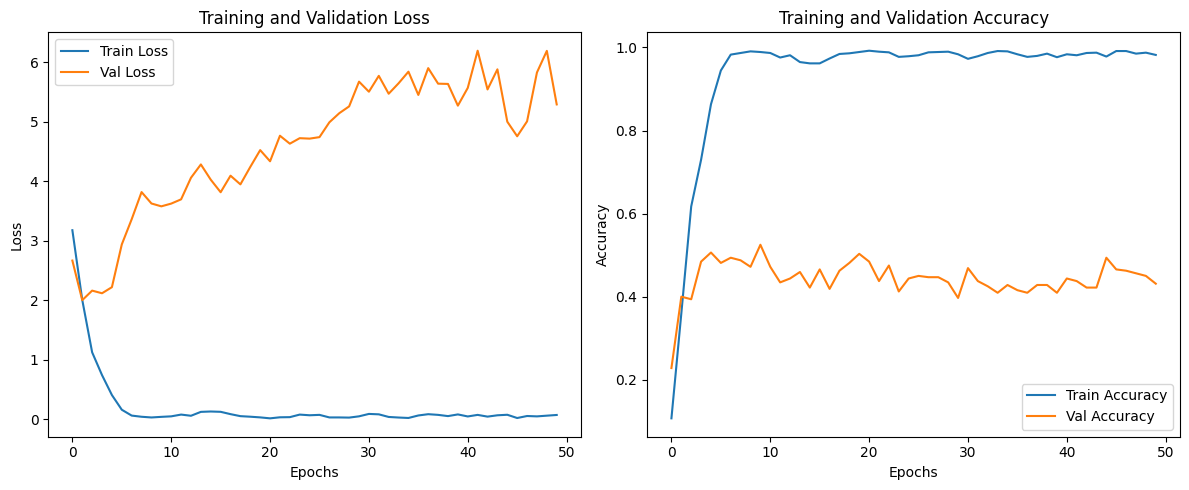

Testing: 100%|██████████| 27/27 [00:00<00:00, 139.68it/s]
<ipython-input-13-4cfbbdee5da0>:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(

Test Loss: 4.8253, Test Accuracy: 0.4821
Test Loss: 4.8253, Test Accuracy: 0.48%
Model saved to dataset_location_Simple_Net.pth


Evaluating Test Data: 100%|██████████| 27/27 [00:00<00:00, 93.38it/s]


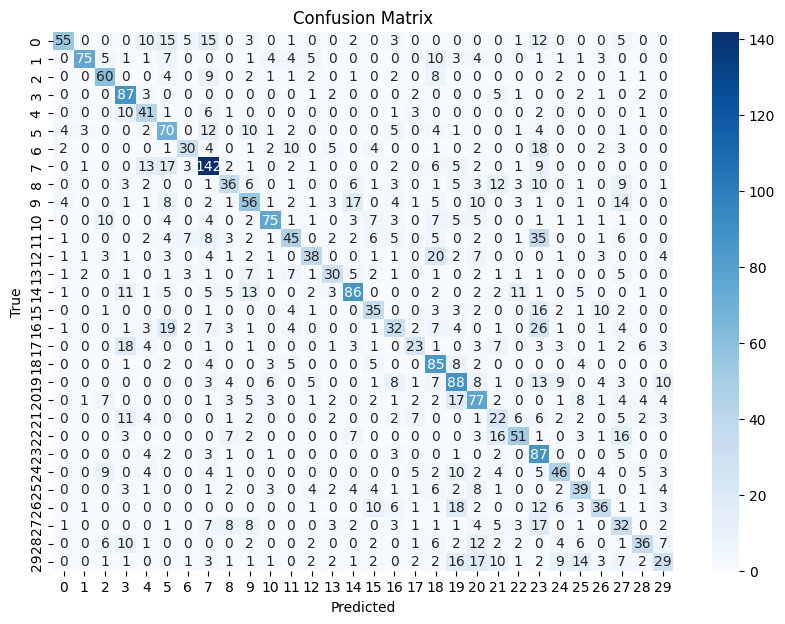

In [ ]:
train_and_evaluate(
    model = initialize_Simple_Net(dataset_location_path) ,
    folder_path = dataset_location_path,
    dataset_name = "dataset_location",
    num_of_train=1600,
    epochs=50,
    lr=0.01,
)

# dataset dataset texas 100

In [25]:
model = initialize_Simple_Net(dataset_texas_path, verbose=True)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       3,159,040
            Linear-2                  [-1, 256]         131,328
            Linear-3                  [-1, 128]          32,896
            Linear-4                  [-1, 100]          12,900
Total params: 3,336,164
Trainable params: 3,336,164
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.01
Params size (MB): 12.73
Estimated Total Size (MB): 12.76
----------------------------------------------------------------
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Simple_Net(
  (fc1): Linear(in_features=6169, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(

/content/drive/MyDrive/Sxoli/EFREMIDIS/Dataset_Baseline/data/dataset_texas/100/features found.
/content/drive/MyDrive/Sxoli/EFREMIDIS/Dataset_Baseline/data/dataset_texas/100/labels found.
[92 92 92]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]]
lenght of all the data is : 67330
Length of training data: 10000
Length of testing data: 57330
num of labels: 100
Training size: 8000, Validation size: 2000
torch.Size([128, 6169])
torch.Size([128])
Epoch 1/100 - Learning Rate: 0.01


Epoch 1/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 48.43it/s]


Epoch 1/100 - Train Loss: 3.6106, Train Acc: 0.1736 - Val Loss: 2.7172, Val Acc: 0.3160
Epoch 2/100 - Learning Rate: 0.01


Epoch 2/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 50.53it/s]


Epoch 2/100 - Train Loss: 2.0889, Train Acc: 0.4326 - Val Loss: 1.9996, Val Acc: 0.4710
Epoch 3/100 - Learning Rate: 0.01


Epoch 3/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 38.73it/s]


Epoch 3/100 - Train Loss: 1.2919, Train Acc: 0.5916 - Val Loss: 2.0527, Val Acc: 0.4825
Epoch 4/100 - Learning Rate: 0.01


Epoch 4/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 48.62it/s]


Epoch 4/100 - Train Loss: 0.8146, Train Acc: 0.7261 - Val Loss: 2.3465, Val Acc: 0.4790
Epoch 5/100 - Learning Rate: 0.01


Epoch 5/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 31.53it/s]


Epoch 5/100 - Train Loss: 0.5241, Train Acc: 0.8280 - Val Loss: 2.7434, Val Acc: 0.4695
Epoch 6/100 - Learning Rate: 0.01


Epoch 6/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 48.27it/s]


Epoch 6/100 - Train Loss: 0.3552, Train Acc: 0.8882 - Val Loss: 2.9801, Val Acc: 0.4555
Epoch 7/100 - Learning Rate: 0.01


Epoch 7/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 32.68it/s]


Epoch 7/100 - Train Loss: 0.2448, Train Acc: 0.9263 - Val Loss: 3.3704, Val Acc: 0.4705
Epoch 8/100 - Learning Rate: 0.01


Epoch 8/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 49.18it/s]


Epoch 8/100 - Train Loss: 0.2081, Train Acc: 0.9401 - Val Loss: 3.5613, Val Acc: 0.4775
Epoch 9/100 - Learning Rate: 0.01


Epoch 9/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 50.93it/s]


Epoch 9/100 - Train Loss: 0.1302, Train Acc: 0.9637 - Val Loss: 4.0129, Val Acc: 0.4680
Epoch 10/100 - Learning Rate: 0.01


Epoch 10/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 31.17it/s]


Epoch 10/100 - Train Loss: 0.1230, Train Acc: 0.9643 - Val Loss: 4.3328, Val Acc: 0.4680
Epoch 11/100 - Learning Rate: 0.01


Epoch 11/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 49.34it/s]


Epoch 11/100 - Train Loss: 0.1474, Train Acc: 0.9577 - Val Loss: 4.4018, Val Acc: 0.4680
Epoch 12/100 - Learning Rate: 0.01


Epoch 12/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 31.70it/s]


Epoch 12/100 - Train Loss: 0.1873, Train Acc: 0.9476 - Val Loss: 4.5523, Val Acc: 0.4630
Epoch 13/100 - Learning Rate: 0.01


Epoch 13/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 49.41it/s]


Epoch 13/100 - Train Loss: 0.2190, Train Acc: 0.9427 - Val Loss: 4.3576, Val Acc: 0.4680
Epoch 14/100 - Learning Rate: 0.01


Epoch 14/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 30.80it/s]


Epoch 14/100 - Train Loss: 0.1912, Train Acc: 0.9545 - Val Loss: 4.5277, Val Acc: 0.4665
Epoch 15/100 - Learning Rate: 0.01


Epoch 15/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 50.08it/s]


Epoch 15/100 - Train Loss: 0.1672, Train Acc: 0.9590 - Val Loss: 4.5361, Val Acc: 0.4765
Epoch 16/100 - Learning Rate: 0.01


Epoch 16/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 49.98it/s]


Epoch 16/100 - Train Loss: 0.1524, Train Acc: 0.9589 - Val Loss: 5.2304, Val Acc: 0.4570
Epoch 17/100 - Learning Rate: 0.01


Epoch 17/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 50.27it/s]


Epoch 17/100 - Train Loss: 0.1619, Train Acc: 0.9610 - Val Loss: 5.0972, Val Acc: 0.4705
Epoch 18/100 - Learning Rate: 0.01


Epoch 18/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 51.33it/s]


Epoch 18/100 - Train Loss: 0.1557, Train Acc: 0.9620 - Val Loss: 5.3883, Val Acc: 0.4645
Epoch 19/100 - Learning Rate: 0.01


Epoch 19/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 48.55it/s]


Epoch 19/100 - Train Loss: 0.1586, Train Acc: 0.9635 - Val Loss: 5.1750, Val Acc: 0.4545
Epoch 20/100 - Learning Rate: 0.01


Epoch 20/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 48.59it/s]


Epoch 20/100 - Train Loss: 0.1643, Train Acc: 0.9646 - Val Loss: 5.2333, Val Acc: 0.4545
Epoch 21/100 - Learning Rate: 0.01


Epoch 21/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 31.33it/s]


Epoch 21/100 - Train Loss: 0.1315, Train Acc: 0.9699 - Val Loss: 5.2469, Val Acc: 0.4500
Epoch 22/100 - Learning Rate: 0.01


Epoch 22/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 49.34it/s]


Epoch 22/100 - Train Loss: 0.1362, Train Acc: 0.9718 - Val Loss: 5.8296, Val Acc: 0.4590
Epoch 23/100 - Learning Rate: 0.01


Epoch 23/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 36.04it/s]


Epoch 23/100 - Train Loss: 0.1277, Train Acc: 0.9700 - Val Loss: 5.8868, Val Acc: 0.4640
Epoch 24/100 - Learning Rate: 0.01


Epoch 24/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 49.89it/s]


Epoch 24/100 - Train Loss: 0.1459, Train Acc: 0.9695 - Val Loss: 5.7354, Val Acc: 0.4740
Epoch 25/100 - Learning Rate: 0.01


Epoch 25/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 51.89it/s]


Epoch 25/100 - Train Loss: 0.1715, Train Acc: 0.9669 - Val Loss: 6.0686, Val Acc: 0.4545
Epoch 26/100 - Learning Rate: 0.01


Epoch 26/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 31.03it/s]


Epoch 26/100 - Train Loss: 0.1385, Train Acc: 0.9724 - Val Loss: 6.3549, Val Acc: 0.4395
Epoch 27/100 - Learning Rate: 0.01


Epoch 27/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 49.31it/s]


Epoch 27/100 - Train Loss: 0.0949, Train Acc: 0.9756 - Val Loss: 6.3357, Val Acc: 0.4620
Epoch 28/100 - Learning Rate: 0.01


Epoch 28/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 28.53it/s]


Epoch 28/100 - Train Loss: 0.0884, Train Acc: 0.9825 - Val Loss: 6.6057, Val Acc: 0.4625
Epoch 29/100 - Learning Rate: 0.01


Epoch 29/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 48.34it/s]


Epoch 29/100 - Train Loss: 0.0941, Train Acc: 0.9809 - Val Loss: 6.5790, Val Acc: 0.4670
Epoch 30/100 - Learning Rate: 0.01


Epoch 30/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 48.64it/s]


Epoch 30/100 - Train Loss: 0.1043, Train Acc: 0.9810 - Val Loss: 6.8414, Val Acc: 0.4605
Epoch 31/100 - Learning Rate: 0.01


Epoch 31/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 30.28it/s]


Epoch 31/100 - Train Loss: 0.1209, Train Acc: 0.9806 - Val Loss: 6.9332, Val Acc: 0.4610
Epoch 32/100 - Learning Rate: 0.01


Epoch 32/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 49.43it/s]


Epoch 32/100 - Train Loss: 0.1091, Train Acc: 0.9770 - Val Loss: 7.2172, Val Acc: 0.4660
Epoch 33/100 - Learning Rate: 0.01


Epoch 33/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 30.81it/s]


Epoch 33/100 - Train Loss: 0.1947, Train Acc: 0.9664 - Val Loss: 7.2980, Val Acc: 0.4545
Epoch 34/100 - Learning Rate: 0.01


Epoch 34/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 46.59it/s]


Epoch 34/100 - Train Loss: 0.2499, Train Acc: 0.9586 - Val Loss: 6.6626, Val Acc: 0.4530
Epoch 35/100 - Learning Rate: 0.01


Epoch 35/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 45.77it/s]


Epoch 35/100 - Train Loss: 0.1757, Train Acc: 0.9696 - Val Loss: 6.7950, Val Acc: 0.4620
Epoch 36/100 - Learning Rate: 0.01


Epoch 36/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 31.43it/s]


Epoch 36/100 - Train Loss: 0.1499, Train Acc: 0.9738 - Val Loss: 7.2469, Val Acc: 0.4495
Epoch 37/100 - Learning Rate: 0.01


Epoch 37/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 48.35it/s]


Epoch 37/100 - Train Loss: 0.1562, Train Acc: 0.9749 - Val Loss: 7.4381, Val Acc: 0.4670
Epoch 38/100 - Learning Rate: 0.01


Epoch 38/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 49.78it/s]


Epoch 38/100 - Train Loss: 0.1644, Train Acc: 0.9749 - Val Loss: 7.3162, Val Acc: 0.4795
Epoch 39/100 - Learning Rate: 0.01


Epoch 39/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 48.85it/s]


Epoch 39/100 - Train Loss: 0.1155, Train Acc: 0.9804 - Val Loss: 7.2713, Val Acc: 0.4665
Epoch 40/100 - Learning Rate: 0.01


Epoch 40/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 46.66it/s]


Epoch 40/100 - Train Loss: 0.0924, Train Acc: 0.9852 - Val Loss: 7.1127, Val Acc: 0.4755
Epoch 41/100 - Learning Rate: 0.01


Epoch 41/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 30.00it/s]


Epoch 41/100 - Train Loss: 0.0543, Train Acc: 0.9918 - Val Loss: 7.3307, Val Acc: 0.4685
Epoch 42/100 - Learning Rate: 0.01


Epoch 42/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 47.91it/s]


Epoch 42/100 - Train Loss: 0.0418, Train Acc: 0.9921 - Val Loss: 7.6770, Val Acc: 0.4565
Epoch 43/100 - Learning Rate: 0.01


Epoch 43/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 50.73it/s]


Epoch 43/100 - Train Loss: 0.0298, Train Acc: 0.9936 - Val Loss: 7.8745, Val Acc: 0.4680
Epoch 44/100 - Learning Rate: 0.01


Epoch 44/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 31.40it/s]


Epoch 44/100 - Train Loss: 0.0330, Train Acc: 0.9942 - Val Loss: 8.5836, Val Acc: 0.4635
Epoch 45/100 - Learning Rate: 0.01


Epoch 45/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 50.81it/s]


Epoch 45/100 - Train Loss: 0.0660, Train Acc: 0.9901 - Val Loss: 8.3383, Val Acc: 0.4625
Epoch 46/100 - Learning Rate: 0.01


Epoch 46/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 34.75it/s]


Epoch 46/100 - Train Loss: 0.0919, Train Acc: 0.9861 - Val Loss: 8.5654, Val Acc: 0.4640
Epoch 47/100 - Learning Rate: 0.01


Epoch 47/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 45.36it/s]


Epoch 47/100 - Train Loss: 0.1212, Train Acc: 0.9810 - Val Loss: 8.9378, Val Acc: 0.4420
Epoch 48/100 - Learning Rate: 0.01


Epoch 48/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 51.28it/s]


Epoch 48/100 - Train Loss: 0.1751, Train Acc: 0.9730 - Val Loss: 9.1023, Val Acc: 0.4550
Epoch 49/100 - Learning Rate: 0.01


Epoch 49/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 32.87it/s]


Epoch 49/100 - Train Loss: 0.2656, Train Acc: 0.9639 - Val Loss: 9.5239, Val Acc: 0.4310
Epoch 50/100 - Learning Rate: 0.01


Epoch 50/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 50.82it/s]


Epoch 50/100 - Train Loss: 0.3204, Train Acc: 0.9560 - Val Loss: 8.7020, Val Acc: 0.4550
Epoch 51/100 - Learning Rate: 0.01


Epoch 51/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 48.27it/s]


Epoch 51/100 - Train Loss: 0.3436, Train Acc: 0.9543 - Val Loss: 8.4784, Val Acc: 0.4395
Epoch 52/100 - Learning Rate: 0.01


Epoch 52/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 32.79it/s]


Epoch 52/100 - Train Loss: 0.2521, Train Acc: 0.9647 - Val Loss: 9.0620, Val Acc: 0.4595
Epoch 53/100 - Learning Rate: 0.01


Epoch 53/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 47.71it/s]


Epoch 53/100 - Train Loss: 0.2389, Train Acc: 0.9718 - Val Loss: 9.0502, Val Acc: 0.4605
Epoch 54/100 - Learning Rate: 0.01


Epoch 54/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 43.89it/s]


Epoch 54/100 - Train Loss: 0.1895, Train Acc: 0.9758 - Val Loss: 8.8679, Val Acc: 0.4690
Epoch 55/100 - Learning Rate: 0.01


Epoch 55/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 44.86it/s]


Epoch 55/100 - Train Loss: 0.1746, Train Acc: 0.9759 - Val Loss: 9.9934, Val Acc: 0.4625
Epoch 56/100 - Learning Rate: 0.01


Epoch 56/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 46.04it/s]


Epoch 56/100 - Train Loss: 0.1724, Train Acc: 0.9794 - Val Loss: 10.2301, Val Acc: 0.4580
Epoch 57/100 - Learning Rate: 0.01


Epoch 57/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 30.93it/s]


Epoch 57/100 - Train Loss: 0.1281, Train Acc: 0.9806 - Val Loss: 10.6768, Val Acc: 0.4605
Epoch 58/100 - Learning Rate: 0.01


Epoch 58/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 49.63it/s]


Epoch 58/100 - Train Loss: 0.1240, Train Acc: 0.9809 - Val Loss: 12.1865, Val Acc: 0.4680
Epoch 59/100 - Learning Rate: 0.01


Epoch 59/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 47.68it/s]


Epoch 59/100 - Train Loss: 0.1225, Train Acc: 0.9842 - Val Loss: 11.2639, Val Acc: 0.4660
Epoch 60/100 - Learning Rate: 0.01


Epoch 60/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 30.41it/s]


Epoch 60/100 - Train Loss: 0.0991, Train Acc: 0.9854 - Val Loss: 10.9238, Val Acc: 0.4780
Epoch 61/100 - Learning Rate: 0.01


Epoch 61/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 47.97it/s]


Epoch 61/100 - Train Loss: 0.1180, Train Acc: 0.9845 - Val Loss: 11.7340, Val Acc: 0.4775
Epoch 62/100 - Learning Rate: 0.01


Epoch 62/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 48.31it/s]


Epoch 62/100 - Train Loss: 0.1265, Train Acc: 0.9839 - Val Loss: 12.4193, Val Acc: 0.4755
Epoch 63/100 - Learning Rate: 0.01


Epoch 63/100 (Validation): 100%|██████████| 16/16 [00:01<00:00, 10.04it/s]


Epoch 63/100 - Train Loss: 0.1590, Train Acc: 0.9815 - Val Loss: 12.4704, Val Acc: 0.4650
Epoch 64/100 - Learning Rate: 0.01


Epoch 64/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 46.89it/s]


Epoch 64/100 - Train Loss: 0.1561, Train Acc: 0.9802 - Val Loss: 12.3802, Val Acc: 0.4730
Epoch 65/100 - Learning Rate: 0.01


Epoch 65/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 45.03it/s]


Epoch 65/100 - Train Loss: 0.1665, Train Acc: 0.9814 - Val Loss: 11.9111, Val Acc: 0.4645
Epoch 66/100 - Learning Rate: 0.01


Epoch 66/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 47.61it/s]


Epoch 66/100 - Train Loss: 0.1789, Train Acc: 0.9840 - Val Loss: 12.2701, Val Acc: 0.4540
Epoch 67/100 - Learning Rate: 0.01


Epoch 67/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 48.50it/s]


Epoch 67/100 - Train Loss: 0.2051, Train Acc: 0.9820 - Val Loss: 11.7837, Val Acc: 0.4750
Epoch 68/100 - Learning Rate: 0.01


Epoch 68/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 30.24it/s]


Epoch 68/100 - Train Loss: 0.2006, Train Acc: 0.9806 - Val Loss: 11.8308, Val Acc: 0.4700
Epoch 69/100 - Learning Rate: 0.01


Epoch 69/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 46.24it/s]


Epoch 69/100 - Train Loss: 0.1497, Train Acc: 0.9816 - Val Loss: 11.9167, Val Acc: 0.4690
Epoch 70/100 - Learning Rate: 0.01


Epoch 70/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 44.85it/s]


Epoch 70/100 - Train Loss: 0.1513, Train Acc: 0.9850 - Val Loss: 11.7716, Val Acc: 0.4670
Epoch 71/100 - Learning Rate: 0.01


Epoch 71/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 27.66it/s]


Epoch 71/100 - Train Loss: 0.1552, Train Acc: 0.9849 - Val Loss: 12.6373, Val Acc: 0.4680
Epoch 72/100 - Learning Rate: 0.01


Epoch 72/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 44.34it/s]


Epoch 72/100 - Train Loss: 0.1319, Train Acc: 0.9861 - Val Loss: 11.8017, Val Acc: 0.4640
Epoch 73/100 - Learning Rate: 0.01


Epoch 73/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 47.58it/s]


Epoch 73/100 - Train Loss: 0.1028, Train Acc: 0.9884 - Val Loss: 12.4346, Val Acc: 0.4580
Epoch 74/100 - Learning Rate: 0.01


Epoch 74/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 29.26it/s]


Epoch 74/100 - Train Loss: 0.1202, Train Acc: 0.9871 - Val Loss: 12.9737, Val Acc: 0.4625
Epoch 75/100 - Learning Rate: 0.01


Epoch 75/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 44.93it/s]


Epoch 75/100 - Train Loss: 0.0713, Train Acc: 0.9902 - Val Loss: 12.8575, Val Acc: 0.4830
Epoch 76/100 - Learning Rate: 0.01


Epoch 76/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 27.55it/s]


Epoch 76/100 - Train Loss: 0.0739, Train Acc: 0.9926 - Val Loss: 12.1962, Val Acc: 0.4765
Epoch 77/100 - Learning Rate: 0.01


Epoch 77/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 49.09it/s]


Epoch 77/100 - Train Loss: 0.0823, Train Acc: 0.9938 - Val Loss: 12.5180, Val Acc: 0.4825
Epoch 78/100 - Learning Rate: 0.01


Epoch 78/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 38.12it/s]


Epoch 78/100 - Train Loss: 0.0464, Train Acc: 0.9934 - Val Loss: 13.1185, Val Acc: 0.4750
Epoch 79/100 - Learning Rate: 0.01


Epoch 79/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 47.14it/s]


Epoch 79/100 - Train Loss: 0.0312, Train Acc: 0.9950 - Val Loss: 13.3194, Val Acc: 0.4665
Epoch 80/100 - Learning Rate: 0.01


Epoch 80/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 45.17it/s]


Epoch 80/100 - Train Loss: 0.0649, Train Acc: 0.9930 - Val Loss: 13.7242, Val Acc: 0.4690
Epoch 81/100 - Learning Rate: 0.01


Epoch 81/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 24.65it/s]


Epoch 81/100 - Train Loss: 0.0862, Train Acc: 0.9920 - Val Loss: 13.8335, Val Acc: 0.4695
Epoch 82/100 - Learning Rate: 0.01


Epoch 82/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 44.23it/s]


Epoch 82/100 - Train Loss: 0.0824, Train Acc: 0.9900 - Val Loss: 15.0427, Val Acc: 0.4695
Epoch 83/100 - Learning Rate: 0.01


Epoch 83/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 27.34it/s]


Epoch 83/100 - Train Loss: 0.1503, Train Acc: 0.9860 - Val Loss: 15.0151, Val Acc: 0.4665
Epoch 84/100 - Learning Rate: 0.01


Epoch 84/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 46.91it/s]


Epoch 84/100 - Train Loss: 0.2477, Train Acc: 0.9808 - Val Loss: 15.0047, Val Acc: 0.4615
Epoch 85/100 - Learning Rate: 0.01


Epoch 85/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 47.77it/s]


Epoch 85/100 - Train Loss: 0.2195, Train Acc: 0.9784 - Val Loss: 15.1304, Val Acc: 0.4615
Epoch 86/100 - Learning Rate: 0.01


Epoch 86/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 30.47it/s]


Epoch 86/100 - Train Loss: 0.2853, Train Acc: 0.9745 - Val Loss: 14.8901, Val Acc: 0.4600
Epoch 87/100 - Learning Rate: 0.01


Epoch 87/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 46.50it/s]


Epoch 87/100 - Train Loss: 0.3790, Train Acc: 0.9704 - Val Loss: 15.4767, Val Acc: 0.4595
Epoch 88/100 - Learning Rate: 0.01


Epoch 88/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 40.08it/s]


Epoch 88/100 - Train Loss: 0.3165, Train Acc: 0.9791 - Val Loss: 15.9723, Val Acc: 0.4670
Epoch 89/100 - Learning Rate: 0.01


Epoch 89/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 30.64it/s]


Epoch 89/100 - Train Loss: 0.2404, Train Acc: 0.9779 - Val Loss: 15.4088, Val Acc: 0.4725
Epoch 90/100 - Learning Rate: 0.01


Epoch 90/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 48.98it/s]


Epoch 90/100 - Train Loss: 0.2651, Train Acc: 0.9766 - Val Loss: 15.1804, Val Acc: 0.4710
Epoch 91/100 - Learning Rate: 0.01


Epoch 91/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 44.35it/s]


Epoch 91/100 - Train Loss: 0.2181, Train Acc: 0.9810 - Val Loss: 16.2849, Val Acc: 0.4715
Epoch 92/100 - Learning Rate: 0.01


Epoch 92/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 31.03it/s]


Epoch 92/100 - Train Loss: 0.2254, Train Acc: 0.9806 - Val Loss: 15.4720, Val Acc: 0.4640
Epoch 93/100 - Learning Rate: 0.01


Epoch 93/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 43.26it/s]


Epoch 93/100 - Train Loss: 0.2409, Train Acc: 0.9831 - Val Loss: 16.2526, Val Acc: 0.4695
Epoch 94/100 - Learning Rate: 0.01


Epoch 94/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 44.35it/s]


Epoch 94/100 - Train Loss: 0.2152, Train Acc: 0.9858 - Val Loss: 16.2435, Val Acc: 0.4655
Epoch 95/100 - Learning Rate: 0.01


Epoch 95/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 47.05it/s]


Epoch 95/100 - Train Loss: 0.1508, Train Acc: 0.9876 - Val Loss: 16.6118, Val Acc: 0.4785
Epoch 96/100 - Learning Rate: 0.01


Epoch 96/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 47.68it/s]


Epoch 96/100 - Train Loss: 0.2240, Train Acc: 0.9846 - Val Loss: 17.1850, Val Acc: 0.4750
Epoch 97/100 - Learning Rate: 0.01


Epoch 97/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 50.54it/s]


Epoch 97/100 - Train Loss: 0.1796, Train Acc: 0.9850 - Val Loss: 16.9488, Val Acc: 0.4710
Epoch 98/100 - Learning Rate: 0.01


Epoch 98/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 28.89it/s]


Epoch 98/100 - Train Loss: 0.0932, Train Acc: 0.9901 - Val Loss: 16.5277, Val Acc: 0.4690
Epoch 99/100 - Learning Rate: 0.01


Epoch 99/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 49.49it/s]


Epoch 99/100 - Train Loss: 0.0595, Train Acc: 0.9940 - Val Loss: 16.7548, Val Acc: 0.4755
Epoch 100/100 - Learning Rate: 0.01


Epoch 100/100 (Validation): 100%|██████████| 16/16 [00:00<00:00, 46.97it/s]


Epoch 100/100 - Train Loss: 0.0337, Train Acc: 0.9965 - Val Loss: 17.0193, Val Acc: 0.4800


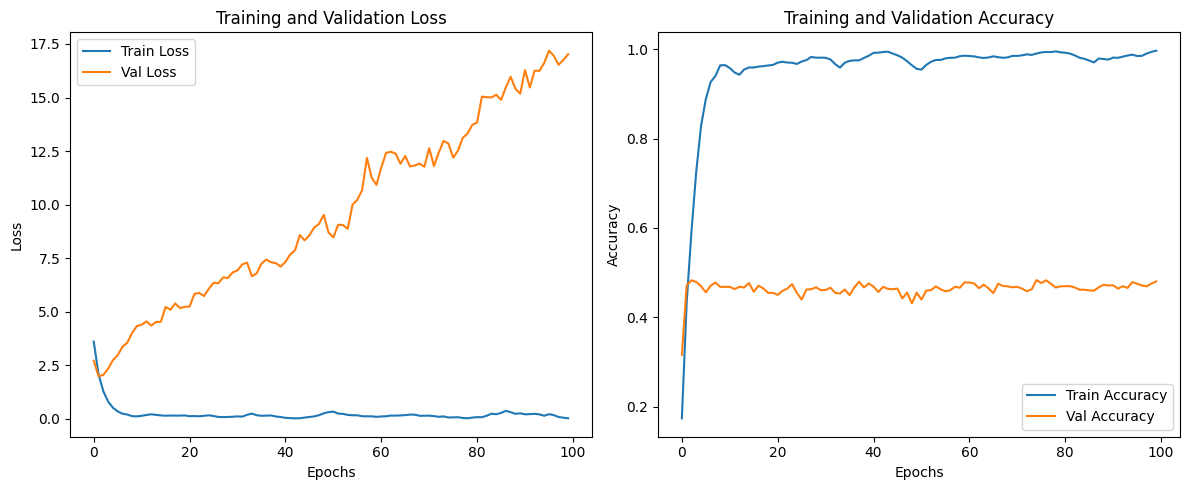

Testing: 100%|██████████| 448/448 [00:11<00:00, 39.85it/s]
<ipython-input-13-4cfbbdee5da0>:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load

Test Loss: 17.9041, Test Accuracy: 0.4534
Test Loss: 17.9041, Test Accuracy: 0.45%
Model saved to dataset_texas_Simple_Net.pth


Evaluating Test Data: 100%|██████████| 448/448 [00:12<00:00, 37.16it/s]


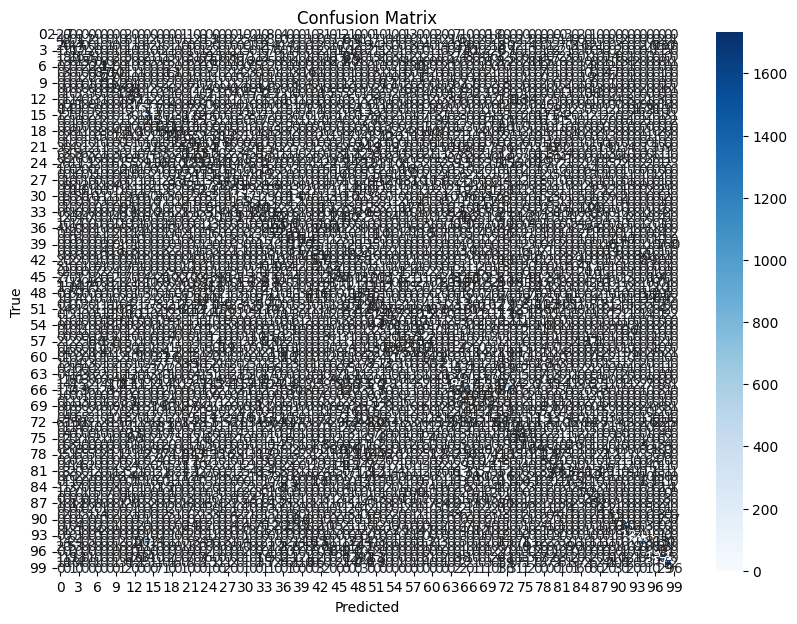

In [28]:
train_and_evaluate(
    model = model ,
    folder_path = dataset_texas_path,
    dataset_name = "dataset_texas",
    num_of_train=10000,
    epochs=100,
    lr=0.01,
)